In [3]:
import insightface
import numpy as np
import cv2 
import os
from os import listdir
from os.path import isfile, join
from keras.models import load_model
from insightface.app import FaceAnalysis
from keras.models import Model
from keras.layers import Dense, GlobalMaxPooling2D, Input
from keras.optimizers import Adam
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionResNetV2

C:\Users\dttan\AppData\Roaming\Python\Python312\site-packages\albumentations\__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.24 (you have 1.4.22). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [4]:
app = FaceAnalysis()
app.prepare(ctx_id=0)

if app.models:
  detector = app.models.get('retinaface_r50_v1', None)
  if detector:
    detector.nms = 0.4

C:\Users\dttan\AppData\Roaming\Python\Python312\site-packages\onnxruntime\capi\onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\dttan/.insightface\models\buffalo_l\1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\dttan/.insightface\models\buffalo_l\2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\dttan/.insightface\models\buffalo_l\det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\dttan/.insightface\models\buffalo_l\genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\dttan/.insightface\models\buffalo_l\w600k_r50.onnx recognition ['None', 3, 112, 112] 127.

In [5]:
base_model = InceptionResNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
  layer.trainable = False
num_classes = 5

x = base_model.output
x = GlobalMaxPooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])
# print(model.summary())


In [4]:
train_dir = "D:/DangTranTanLuc/Data/Train"
val_dir = "D:/DangTranTanLuc/Data/Validate"

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
    fill_mode='nearest'

)
val_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical")
validation_generator = train_datagen.flow_from_directory(
    val_dir  ,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical")
label_map = train_generator.class_indices
label_map = {v: k for k, v in label_map.items()}

print("Label Map:", label_map)

Found 100 images belonging to 5 classes.


Found 25 images belonging to 5 classes.
Label Map: {0: 'Dang Tran Tan Luc', 1: 'Nguyen Thi Ngoc Diem', 2: 'Phung Khanh Duy', 3: 'Vo Nguyen Thanh Dieu', 4: 'Vo Thi Cam Tu'}


In [21]:
checkpoint = ModelCheckpoint("model.keras",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 6,
                          verbose = 1,
                          restore_best_weights = True)

callbacks = [earlystop, checkpoint]
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=25,
    callbacks = callbacks,
    steps_per_epoch=len(train_generator),
    validation_steps=len(validation_generator),
)


Epoch 1/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8840 - loss: 0.2981
Epoch 1: val_loss improved from inf to 1.46698, saving model to model.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step - accuracy: 0.8852 - loss: 0.2996 - val_accuracy: 0.6800 - val_loss: 1.4670
Epoch 2/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7591 - loss: 0.6125
Epoch 3: val_loss improved from 1.46698 to 0.66183, saving model to model.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step - accuracy: 0.7573 - loss: 0.6221 - val_accuracy: 0.7600 - val_loss: 0.6618
Epoch 4/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8363 - loss: 0.3593
Epoch 5: val_loss improved from 0.66183 to 0.64807, saving model to model.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 18s 5s/step - accuracy: 0.8370 - loss: 0.3596 - val_accuracy: 0.7600 - val_loss: 0.6481


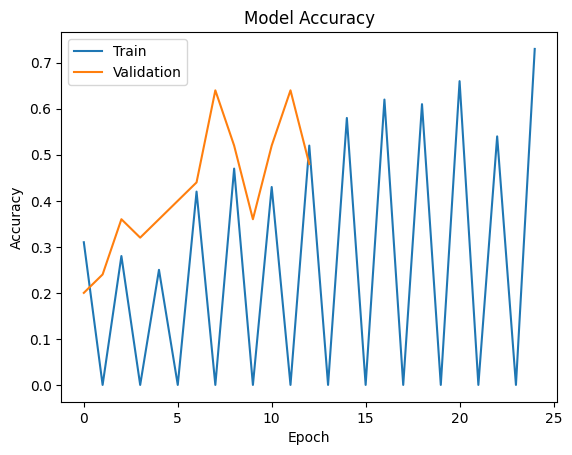

In [15]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [7]:
classifier = load_model("D:/DangTranTanLuc/Python/ProjectPy/FaceRecognitionSystem/model.keras")


def draw_test(name, pred, im):
    face = label_map[pred[0]]
    BLACK = [0,0,0]
    expanded_image = cv2.copyMakeBorder(im, 80, 0, 0, 100 ,cv2.BORDER_CONSTANT,value=BLACK)
    cv2.putText(expanded_image, face, (20, 60) , cv2.FONT_HERSHEY_SIMPLEX,0.5, (0,0,255), 1)
    cv2.imshow("Prediction", expanded_image)

def getRandomImage(path):
    """function loads a random images from a random folder in our test path """
    folders = list(filter(lambda x: os.path.isdir(os.path.join(path, x)), os.listdir(path)))
    random_directory = np.random.randint(0,len(folders))
    path_class = folders[random_directory]
    print("Class - " + path_class)
    file_path = path + path_class
    file_names = [f for f in listdir(file_path) if isfile(join(file_path, f))]
    random_file_index = np.random.randint(0,len(file_names))
    image_name = file_names[random_file_index]
    return cv2.imread(file_path+"/"+image_name)

for i in range(0,10):
    input_im = getRandomImage("D:/DangTranTanLuc/Data/Validate/")
    input_original = input_im.copy()
    input_original = cv2.resize(input_original, None, fx=0.5, fy=0.5, interpolation = cv2.INTER_LINEAR)

    input_im = cv2.resize(input_im, (224, 224), interpolation = cv2.INTER_LINEAR)
    input_im = input_im / 255.
    input_im = input_im.reshape(1,224,224,3)

    res = np.argmax(classifier.predict(input_im, 1, verbose = 0), axis=1)

    draw_test("Prediction", res, input_original)
    cv2.waitKey(0)

cv2.destroyAllWindows()

Class - Vo Nguyen Thanh Dieu
Class - Phung Khanh Duy
Class - Phung Khanh Duy
Class - Vo Thi Cam Tu
Class - Vo Thi Cam Tu
Class - Vo Nguyen Thanh Dieu
Class - Vo Nguyen Thanh Dieu
Class - Dang Tran Tan Luc
Class - Phung Khanh Duy
Class - Vo Thi Cam Tu


In [8]:
classifier = load_model("D:/DangTranTanLuc/Python/ProjectPy/FaceRecognitionSystem/model.keras")
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [9]:
import cv2
import numpy as np
from PIL import Image

label_map = {0: 'Dang Tran Tan Luc', 1: 'Nguyen Thi Ngoc Diem', 2: 'Phung Khanh Duy', 3: 'Vo Nguyen Thanh Dieu', 4: 'Vo Thi Cam Tu'}


def face_extractor(img):
    faces = face_cascade.detectMultiScale(img, 1.3, 5)
    if len(faces) == 0: 
        return None

    for (x, y, w, h) in faces:
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 255), 2)
        cropped_face = img[y:y + h, x:x + w]
        return cropped_face 

    return None

video_capture = cv2.VideoCapture(0)

if not video_capture.isOpened():
    print("Error: Cannot access the webcam.")
    exit()

while True:
    ret, frame = video_capture.read() 
    if not ret:
        print("Failed to capture frame. Exiting...")
        break

    face = face_extractor(frame)
    if face is not None:
        try:
            face = cv2.resize(face, (224, 224))
            im = Image.fromarray(face, 'RGB')
            img_array = np.array(im)
            img_array = np.expand_dims(img_array, axis=0) / 255.0

            pred = classifier.predict(img_array)
            predicted_class = np.argmax(pred, axis=1)
            name = label_map[predicted_class[0]]

            cv2.putText(frame, name, (50, 50), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 255, 0), 2)
        except Exception as e:
            print(f"Error during face processing: {e}")
    else:
        cv2.putText(frame, "No face detected", (50, 50), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 255, 0), 2)

    if frame is not None and frame.size > 0:
        cv2.imshow('Video', frame)
    else:
        print("Empty frame detected. Skipping...")

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

video_capture.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


In [6]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import numpy as np

In [7]:
base_model = ResNet50(weights="imagenet", include_top=False, pooling='avg')
img_path = "C:\\Users\\dttan\\Pictures\\danxinhiu.png"
img = image.load_img(img_path, target_size=(224, 224))  

img_array = image.img_to_array(img)  
img_array = np.expand_dims(img_array, axis=0) 
img_array = preprocess_input(img_array) 
print(img_array)


[[[[ -52.939003  -61.779     -67.68    ]
   [ -52.939003  -61.779     -67.68    ]
   [ -52.939003  -61.779     -67.68    ]
   ...
   [ -69.939     -76.779     -76.68    ]
   [ -68.939     -75.779     -75.68    ]
   [ -68.939     -75.779     -75.68    ]]

  [[ -51.939003  -60.779     -66.68    ]
   [ -51.939003  -60.779     -66.68    ]
   [ -51.939003  -60.779     -66.68    ]
   ...
   [ -69.939     -76.779     -76.68    ]
   [ -68.939     -75.779     -75.68    ]
   [ -68.939     -75.779     -75.68    ]]

  [[ -53.939003  -60.779     -68.68    ]
   [ -53.939003  -60.779     -68.68    ]
   [ -53.939003  -60.779     -68.68    ]
   ...
   [ -71.939     -76.779     -76.68    ]
   [ -71.939     -75.779     -75.68    ]
   [ -71.939     -75.779     -75.68    ]]

  ...

  [[ -94.939    -106.779    -106.68    ]
   [ -92.939    -100.779     -94.68    ]
   [ -92.939     -94.779     -79.68    ]
   ...
   [   8.060997   15.221001   24.32    ]
   [  15.060997   20.221      28.32    ]
   [  17.060997 

In [22]:
from tensorflow.keras.models import Model
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from scipy.spatial.distance import cosine
import os

trích xuất dưới dạng vector embedding 


In [23]:
embedding_model = Model(inputs = base_model.input, outputs = x)

#load ảnh lên và chuyển sang arr
def extract_embedding (model, image_path):
    img = load_img(image_path, target_size=(224,224))
    img.show()
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    print(img_array)

    embedding = model.predict(img_array)
    print(embedding)
    return embedding[0]

In [24]:
def extract_embeddings_from_folder(model, folder_path):
    embeddings =[]
    list_folder =[]
    
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        if file_name.lower().endswith(('jpg','png', 'jpeg')):
            try:
                embedding = extract_embedding(model, file_path)
                embeddings.append(embedding)
                list_folder.append(file_path)
            except Exception as e:
                print(f"Error when process {file_path}:{e}")
    return embedding, list_folder  

In [ ]:
folder_path = "D:\python\FaceRecognitionSystem\Data\Jisoo"
embeddings, file_paths = extract_embeddings_from_folder(embedding_model, folder_path)
print("Tất cả embedding đã trích xuất:")
for path, embedding in zip(file_paths, embeddings):
        print(f"Ảnh: {path} - Embedding: {embedding}")



In [ ]:
import os
import matplotlib.pyplot as plt
import cv2 

folder_path = "D:/DangTranTanLuc/Data/Jisoo"

for path in file_paths:
    img = cv2.imread(path)
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.imshow(img)
    plt.axis('off')  
    plt.show()


In [27]:
def get_file_name(folder_path):
    file_name = os.path.basename(folder_path) 
    return file_name


folder_path = "D:\python\FaceRecognitionSystem\Data\Jisoo"
print(get_file_name(folder_path))


def list_files_in_folder(folder_path):
    files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    
    file_path = [os.path.join(folder_path, f) for f in files]
    # files_name_without_extension = [os.path.splitext(f)[0] for f in files]
    # return files_name_without_extension
    return file_path

folder_path = "D:\python\FaceRecognitionSystem\Data\Jisoo"
file_list = list_files_in_folder(folder_path)
print(file_list)

Jisoo
['D:\\python\\FaceRecognitionSystem\\Data\\Jisoo\\Jisoo - 1.png', 'D:\\python\\FaceRecognitionSystem\\Data\\Jisoo\\Jisoo - 10.png', 'D:\\python\\FaceRecognitionSystem\\Data\\Jisoo\\Jisoo - 2.png', 'D:\\python\\FaceRecognitionSystem\\Data\\Jisoo\\Jisoo - 3.png', 'D:\\python\\FaceRecognitionSystem\\Data\\Jisoo\\Jisoo - 4.png', 'D:\\python\\FaceRecognitionSystem\\Data\\Jisoo\\Jisoo - 5.png', 'D:\\python\\FaceRecognitionSystem\\Data\\Jisoo\\Jisoo - 6.png', 'D:\\python\\FaceRecognitionSystem\\Data\\Jisoo\\Jisoo - 7.png', 'D:\\python\\FaceRecognitionSystem\\Data\\Jisoo\\Jisoo - 8.png', 'D:\\python\\FaceRecognitionSystem\\Data\\Jisoo\\Jisoo - 9.png']


<>:6: SyntaxWarning: invalid escape sequence '\p'
<>:18: SyntaxWarning: invalid escape sequence '\p'
<>:6: SyntaxWarning: invalid escape sequence '\p'
<>:18: SyntaxWarning: invalid escape sequence '\p'
C:\Users\dttan\AppData\Local\Temp\ipykernel_17696\37931270.py:6: SyntaxWarning: invalid escape sequence '\p'
  folder_path = "D:\python\FaceRecognitionSystem\Data\Jisoo"
C:\Users\dttan\AppData\Local\Temp\ipykernel_17696\37931270.py:18: SyntaxWarning: invalid escape sequence '\p'
  folder_path = "D:\python\FaceRecognitionSystem\Data\Jisoo"


In [ ]:
#thêm ảnh vào 1 cái dictdict

def add_new_class(embedding_dict, class_name, image_paths, model):
    embeddings =[]
    for image_path in image_paths:
        embedding = extract_embedding(model, image_path)
        embeddings.append(embedding)
       
    embedding_dict[class_name] = embeddings
    print("Tất cả các embedding đã thêm vào dictionary:")
    
    print(embedding_dict.items())
class_embeddings = {"class_name":[]}

folder_path = "D:\python\FaceRecognitionSystem\Data\Jisoo"
folder_path2 =  "D:\python\FaceRecognitionSystem\Data\Rose"
image_paths = list_files_in_folder(folder_path) 
image_paths2 = list_files_in_folder(folder_path2)
add_new_class(class_embeddings, get_file_name(folder_path ), image_paths, embedding_model)
add_new_class(class_embeddings, get_file_name(folder_path2 ), image_paths2, embedding_model)



In [29]:
#tính khoảng cách cosin giữa 2 vector 
def predict_class(embeddings_dict, new_image_embedding):
    min_distance = float("inf")
    predict_class = None

    for class_name, embeddings in embeddings_dict.items():
        for embedding in embeddings:
            distance = cosine(new_image_embedding, embedding)
            if distance < min_distance:
                min_distance = distance
                predict_class = class_name
            else:
                print('Unknown person')

    return predict_class

In [34]:
# new_image_path = "D:\python\FaceRecognitionSystem\Data\Train\Dang Tran Tan Luc\Dang Tran Tan Luc - 3.png"
new_image_path = "D:/python/FaceRecognitionSystem/Data/Dang Tran Tan Luc - 3.png"

new_embedding = extract_embedding(embedding_model, new_image_path)

predicted_class = predict_class(class_embeddings, new_embedding)
print("Predicted Class:", predicted_class)


[[[[ 17.  28.  24.]
   [ 19.  31.  26.]
   [ 15.  26.  22.]
   ...
   [ 14.  32.  28.]
   [ 13.  26.  24.]
   [ 12.  22.  21.]]

  [[ 17.  32.  27.]
   [ 18.  32.  27.]
   [ 16.  29.  24.]
   ...
   [ 14.  30.  27.]
   [ 12.  25.  23.]
   [  9.  20.  19.]]

  [[ 19.  34.  29.]
   [ 17.  32.  27.]
   [ 16.  29.  24.]
   ...
   [  9.  25.  22.]
   [  7.  22.  20.]
   [  8.  18.  17.]]

  ...

  [[218. 173. 136.]
   [211. 167. 132.]
   [210. 168. 132.]
   ...
   [217. 177. 144.]
   [217. 175. 143.]
   [217. 173. 141.]]

  [[212. 168. 132.]
   [211. 167. 132.]
   [212. 169. 134.]
   ...
   [217. 176. 144.]
   [218. 176. 145.]
   [219. 174. 143.]]

  [[210. 168. 132.]
   [215. 171. 136.]
   [215. 171. 136.]
   ...
   [213. 172. 140.]
   [218. 177. 145.]
   [220. 180. 145.]]]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
[[ 84.293526   0.       185.87666  ...   0.       106.1068     0.      ]]
Unknown person
Unknown person
Unknown person
Unknown person
Unknown person
Unknown person
Unknown person
